# Test Match Batting Form Slumps

This project uses test match data aquired from https://cricsheet.org/downloads/. The raw .csv files are processed and compiled into three datasets: 'batting_stats', 'bowling_stats' and 'match_information'. 

The goal of this project is to test whether batsmen experience periods of poor performance or form. Commentators and pundits alike often comment when a batsman fails to produce good scores over a number of matches. The inspiration for this project was taken from the batting results of the 2019 Ashes test series between Australia and England. In this series David Warner scored a total of 95 runs in 10 innings (9.5 average)- an extremely low average. By contrast Steve Smith scored 774 runs in 7 innings (110.57 average)- a remarkably good performance. 

The null hypothesis can be stated as:
    "there is no time dependent correlation of the runs scored by a batsman"

To reject this hypothesis we must show that periods of poor form cannot be accounted for by pure statistical sampling.

The most subjective part of this project is defining what constitutes poor form. One consideration is the number of innings across which we measure form. Choosing too large a window may pick up on longer term trends in batting performance, such as a new player improving over time, or an old players performance declining. Likewise choosing too small a window is likely to be meaningless since scores vary wildly on an innings by innings basis. Motivated by the Ashses test series I choose a window size of 10 innings, though I also look at a smaller 6 innings window as well.

Another consideration is the temporal aspect of each innings and not just the ordinal aspect. Two low scores may be seperated by a year or more. Should this be considered a continuation of poor form? We may want to restrict our analysis to poor batting seasons, where the average number of runs scored across the season is significantly below average. For simplicity I choose not to follow this line of investigation but the results may prove interesting.

Finally the grounds on which the batsman plays, or the opposition that they face, may also influence their average over a period of time. For example a batsman facing a very strong bowling lineup is likely to score lower than against a weaker opposition. Again for simplicity I choose not to follow this line of investigation. 

This project will be split into 6 parts.
    1. Data Exploration and Visualisation
    2. Resampling and Bootstrapping
    3. Smith and Warner Batting Comparison
    4. Ensemble Batting Performances
    5. Possible Longer Term Trends
    6. Summary


## 1. Data Exploration and Visualistation

Here I plot a bar plot of each score for David Warner and Steve Smith placed in chronological order. This gives a sense of the volitility of the data. It appears that a large score is as likely to be followed by a low score as another large score.

Note also that I have colored each score by the 'out' column of the batting dataframe. When considering an average over a period of time the total number of runs scored is divided by the number of times they have been given out.

It is possible to append career averages as well as rolling averages to these plots, and this is done in section 3.

In [17]:
#load libraries

%matplotlib inline
import matplotlib

#basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import random

sns.set(style="whitegrid")

In [18]:
#read in data sets

match_information = pd.read_csv(r'processed_data/match_information.csv')
batting_stats = pd.read_csv(r'processed_data/batting_stats.csv')
bowling_stats = pd.read_csv(r'processed_data/bowling_stats.csv')

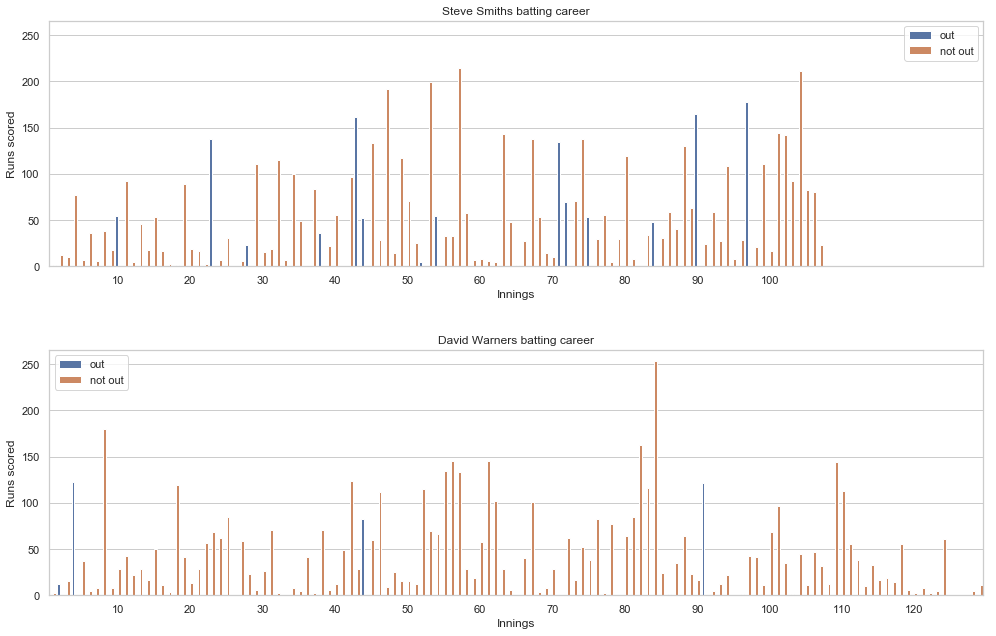

In [20]:
#############################
###### DATA PROCESSING ######
#############################

#### Generate batting bar plot for Steve Smith and David Warner

smith = batting_stats.loc[batting_stats['batsman'] == 'SPD Smith']
warner = batting_stats.loc[batting_stats['batsman'] == 'DA Warner']

window_size = 10

#to sort the career scores of a player we need to get the date of each match from the 
# match_information dataframe. This can be joined on match_id

match_dates = match_information[['start_date','match_id']]

smith = pd.merge(smith, match_dates, how='left', on='match_id')
warner = pd.merge(warner, match_dates, how='left', on='match_id')

#sort 'smith' and 'warner' first on date and then by innings. This will generate a sorted column
#of run scores. Note that the hue of each score can be modified if the batsman is not out. Note that the final 
#two games of the ashes series were not present in the dataset when retrieved 2019/09/25 and have been added manually

smith = smith.sort_values(by = ['start_date', 'innings'])
smith.reset_index(inplace=True, drop=True)
smith['index'] = list(range(1,1+smith.shape[0]))
smith = smith[['innings','runs','out','index']]
# #manually add last two matches in 2019 ashes campaign
df2 = pd.DataFrame([[1, 211, 1, 104], [3, 82, 1, 105], [1, 80, 1, 106], [3, 23, 1, 107]], columns=('innings','runs','out','index'))
smith = smith.append(df2)


warner = warner.sort_values(by = ['start_date', 'innings'])
warner.reset_index(inplace=True, drop=True)
warner['index'] = list(range(1,1+warner.shape[0]))
warner = warner[['innings','runs','out','index']]
# #manually add last two matches in 2019 ashes campaign
df2 = pd.DataFrame([[1, 0, 1,126], [3, 0, 1,127], [1, 5, 1,128], [3, 11, 1,129]], columns=('innings','runs','out','index'))
warner = warner.append(df2)

#generate rolling averages for 'smith' and 'warner'
smith['roll_av'] = smith.runs.rolling(window_size, center=False).sum() / smith.out.rolling(window_size, center=False).sum()
warner['roll_av'] = warner.runs.rolling(window_size, center=False).sum() / warner.out.rolling(window_size, center=False).sum()
smith_mean = smith.runs.sum() / smith.out.sum()
warner_mean = warner.runs.sum() / warner.out.sum()


######################
###### PLOTTING ######
######################

#plot bar graphs of the results
fig, ax2 = plt.subplots(2,1, figsize=(14,9),sharey=True, sharex=True) #set shared axis ticks 


#Steve Smith Batting History

plot_ = sns.barplot(x = 'index', y = 'runs', hue='out', data = smith, ax=ax2[0])
ax2[0].legend(['something','else'])
ax2[0].set_title('Steve Smiths batting career')
ax2[0].set_ylabel('Runs scored')
ax2[0].set_xlabel('Innings')

#set xticks for top graph and set visible
ax2[0].xaxis.set_tick_params(which='both', labelbottom=True)
for label in plot_.get_xticklabels():
    if np.int(label.get_text()) % 10 == 0:  
        label.set_visible(True)
    else:
        label.set_visible(False)


#David Warner Batting History

plot2_ = sns.barplot(x = 'index', y = 'runs', hue='out', data = warner, ax=ax2[1])
ax2[1].set_title('David Warners batting career')
ax2[1].set_ylabel('Runs scored')
ax2[1].set_xlabel('Innings')


#set xticks for bottom graph
for label in plot2_.get_xticklabels():
    if np.int(label.get_text()) % 10 == 0:  
        label.set_visible(True)
    else:
        label.set_visible(False)        


#set legend labels

handles, _ = ax2[0].get_legend_handles_labels()
ax2[0].legend(handles, ["out", "not out"])
handles, _ = ax2[1].get_legend_handles_labels()
ax2[1].legend(handles, ["out", "not out"])
        
        
        
fig.tight_layout(h_pad=3.0)

## 2. Resampling and Bootstrapping

To find how significant a peak or dip in performance is I will perform bootstrapping.

The process first involves resampling a batting career. The resampling chooses (with replacement) scores at random from a career until the total number of innings played is matched by the players actual career. A rolling average with a certain window size is then performed. Note that the average incorporates whether the player is given out or now.

The complete bootstrapping process repeats the resampling step thousands of times (10000 default in this project). Comparisons can then be made between the bootstrap samples and the original career of the player. For example the proportion of bootstrap samples contains a rolling average equal to or less than the players actual lowest rolling average will give a confidence interval for that score.

Experimental Cumulative Distribution Functions (ECDFs) are a way of visualising the confidence intervals corresponding scoring below a certain number or runs. Functions for bootstrapping and plotting confidence intervals are shown in the code below. By default the ECDF function returns confidence intervals for a rolling average below 5%, below 32%, which are appoximately 1 and 2 standard deviatios respectively. The code also calculates the likelyhood of good performance spikes, and confidence intervals of 5% and 32% are given for obtaining a rolling average above a certain number of runs throughout a career. 


### 2.1 Bootstrapping functions

In [4]:
# Create a bootstrapping function for sampling rolling averages from a runslist

##############################
###### DEFINE FUNCTIONS ######
##############################

# bootstrapping function
def bootstrapper(runslist, num_samples):
    """
    generates "num_samples" virtual innings from a "runslist" dataframe.
    """
    
    index_range = runslist.shape[0]
    
    runs_array = (np.empty([num_samples, index_range]))
    outs_array = (np.empty([num_samples, index_range]))
    runs = np.array(runslist['runs'])
    outs = np.array(runslist['out']) #turn runs and outs into numpy arrays
    
    np.random.seed(seed=42)
    
    for x in range(num_samples):
        #chooses sample_size indexes from the runslist
        ##samples = np.random.choice(list(range(runslist.shape[0])), replace=True, size=sample_size)
                       
        random_indices = np.random.randint(0,index_range,index_range) #randomly recreate a batting history
        
        a = runs[(random_indices)]
        runs_array[x,:] = a
        
        b = outs[(random_indices)]
        outs_array[x,:] = b

    
    return runs_array, outs_array


def bootstrap_rolling_averages(runslist, num_samples, window_size):
    """
    Takes a list of player runs across and generates num_samples resampled careers. From these
    resampled careers a rolling average over window_size is taken. The output is 'average_rolling' which is a 
    dataframe where each row corresponds to the rolling average of a resampled career.
    """

    #generate num_samples of resamples career innings for a given runslist                 
    runs_array, outs_array = bootstrapper(runslist,num_samples)


    #generatea a rolling average
    runs_dataframe = pd.DataFrame(runs_array) #columns are innings number while each row is a sample
    outs_dataframe = pd.DataFrame(outs_array)

    runs_rolling = runs_dataframe.rolling(window_size, center=False, axis=1).sum()
    outs_rolling = outs_dataframe.rolling(window_size, center=False, axis=1).sum()

    #rolling average for each resampled innings
    average_rolling = runs_rolling / outs_rolling
    
    return average_rolling


### 2.2 ECDFs (experimental cumulative distribution functions)

In [5]:
# generate an Cumulative ECDF function for the data 
#(ECDF = Experimental Cumulative Distribution Function)

##############################
###### DEFINE FUNCTIONS ######
##############################

def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)

def i_ecdf(data):
    """ Compute ECDF working from right to left"""
    x = np.sort(data)
    x = x[::-1] #resort the data backwards
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)


def ecdf_batting(runslist, window_size, average_rolling,player_name='player',ci=0.95,ci2=0.68):
    """
    Takes the average_rolling output from the bootstrap_rolling_averages function, a runslist, and
    a window size and generates an ECDF (experimental cumulative distribution function) for the 
    probability of a streak of window_size innings having an average above or below a certain level.
    """
    
    below = average_rolling.min(axis=1)
    above = average_rolling.max(axis=1)
    #unslist = smith
    career_mean = runslist.runs.sum() / runslist.out.sum()

    
    #calculate runs at ci

    sorted_mins = average_rolling.min(axis=1)
    sorted_mins = np.sort(sorted_mins)

    ci_ = int(len(sorted_mins)*(1-ci))
    lower_bound = sorted_mins[ci_ - 1]
    ci_ = int(len(sorted_mins)*(1-ci2))
    lower_std = sorted_mins[ci_ -1]

    sorted_maxs = average_rolling.max(axis=1)
    sorted_maxs = np.sort(sorted_maxs)

    ci_ = int(len(sorted_maxs)*(ci))
    upper_bound = sorted_maxs[ci_ - 1]
    ci_ = int(len(sorted_maxs)*(ci2))
    upper_std = sorted_maxs[ci_ - 1]
    

    
    #######################
    ###### PLOT ECDF ######
    #######################
    
    fig, ax3 = plt.subplots(1,1, figsize=(15,8))

    #career average line
    y = [0,1]
    x = [career_mean,career_mean]
    ax3.plot(x,y,color='black',linestyle='-',marker='', alpha = 0.5)
    plt.annotate('Career \n average', (career_mean+4,0.5))

    #upper and lower bounds

    plt.annotate('5% < {:.2f}'.format(lower_bound), (lower_bound,-0.03))
    plt.annotate('5% > {:.2f}'.format(upper_bound), (upper_bound+5,-0.03))
        #fill between
    ax3.axvspan(lower_bound, lower_std, alpha=0.2, color='lightsalmon')
    ax3.axvspan(lower_std, upper_std, alpha=0.2, color='springgreen')
    ax3.axvspan(upper_std, upper_bound, alpha=0.2, color='lightsalmon')


    #ECDF for scoring below a certain benchmark
    x, y = ecdf(below)
    ax3.plot(x,y,color='red',linestyle='',marker='.', markersize=1);

    #ECDF for scoring above a certain benchmark
    x, y = i_ecdf(above)
    ax3.plot(x,y,color='blue',linestyle='',marker='.', markersize=1);

    #set figure labels
    ax3.set_xlabel('Average over {} innings within career'.format(window_size), fontsize=16)
    ax3.set_ylabel('probablility', fontsize=16)
    ax3.set_title('Chance of {} career containing a {} innings average above (blue) or below(red) a given number of runs.'.format(player_name,window_size))
    ax3.set_xlim(0, 250)
    
  
    return (lower_bound, lower_std, upper_std, upper_bound)

## 3. Smith and Warner Batting Comparisons

In this section I compare Steve Smiths and David Warners batting performances. I reproduce the graphs in section 1 as well as adding confidence bounds and displaying rolling averages. To do this I use the functions defined in section 2.

For David Warner
A rolling average over 10 innings of less than 9.5 has a confidence interval of 0.05491
For Steve Smith
A rolling average over 10 innings of less than 9.5 has a confidence interval of 0.00333
Bar plots of Steve Smith and David Warners career batting totals.
 95% confidence intervals are shaded in light red.
 One standard deviation is shaded in green


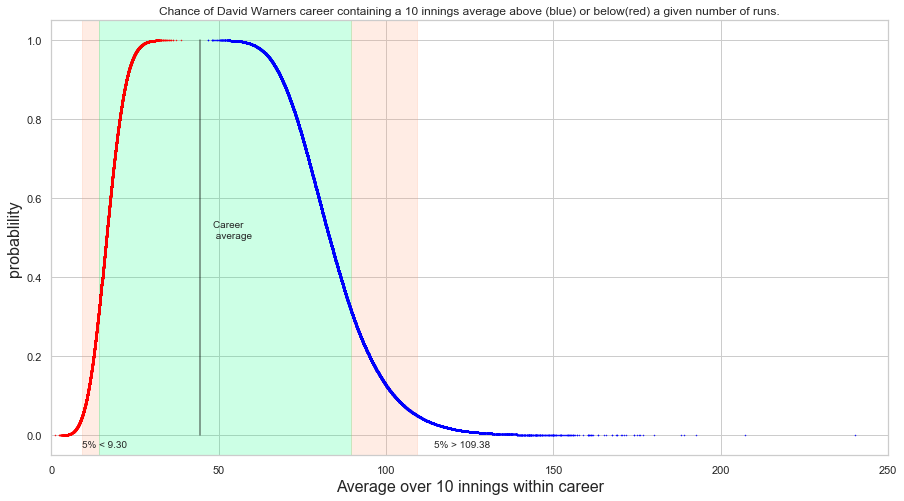

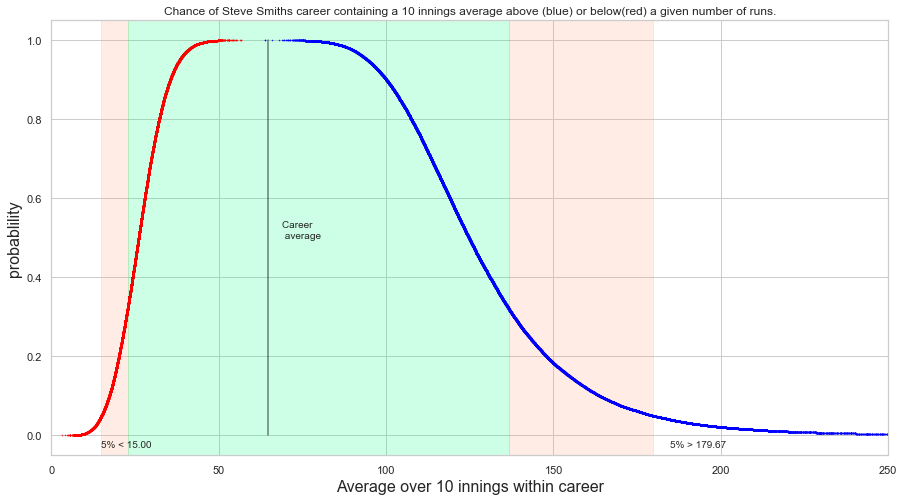

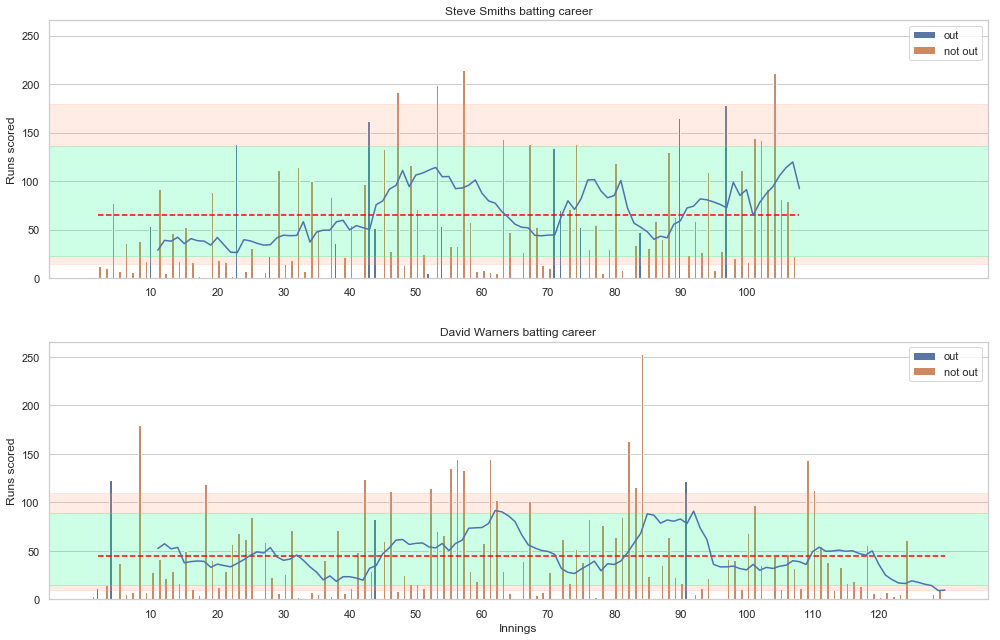

In [14]:
#Determine how likely each player is to score 95 runs in 10 innings like David Warner in the 
# 2019 Ashes series based on resampled career innings

############################
###### SET PARAMETERS ######
############################

num_samples = 100000 #100000 samples takes about 2 seconds to generate runs_array and outs_array
window_size = 10 #window size to rolling average over


#############################
###### DATA PROCESSING ######
#############################

smith = batting_stats.loc[batting_stats['batsman'] == 'SPD Smith']
warner = batting_stats.loc[batting_stats['batsman'] == 'DA Warner']
ci = 0.95 # confidence interval, approx 2 standard deviations
ci2= 0.68 # approximately 1 stardard deviation

#to sort the career scores of a player we need to get the date of each match from the 
# match_information dataframe. This can be joined on match_id

match_dates = match_information[['start_date','match_id']]

smith = pd.merge(smith, match_dates, how='left', on='match_id')
warner = pd.merge(warner, match_dates, how='left', on='match_id')

#sort 'smith' and 'warner' first on date and then by innings. This will generate a sorted column
#of run scores. Note that the hue of each score can be modified if the batsman is not out. Note that the final 
#two games of the ashes series were not present in the dataset when retrieved 2019/09/25 and have been added manually

smith = smith.sort_values(by = ['start_date', 'innings'])
smith.reset_index(inplace=True, drop=True)
smith['index'] = list(range(1,1+smith.shape[0]))
smith = smith[['innings','runs','out','index']]
#manually add last two matches in 2019 ashes campaign
df2 = pd.DataFrame([[1, 211, 1, 104], [3, 82, 1, 105], [1, 80, 1, 106], [3, 23, 1, 107]], columns=('innings','runs','out','index'))
smith = smith.append(df2)


warner = warner.sort_values(by = ['start_date', 'innings'])
warner.reset_index(inplace=True, drop=True)
warner['index'] = list(range(1,1+warner.shape[0]))
warner = warner[['innings','runs','out','index']]
#manually add last two matches in 2019 ashes campaign
df2 = pd.DataFrame([[1, 0, 1,126], [3, 0, 1,127], [1, 5, 1,128], [3, 11, 1,129]], columns=('innings','runs','out','index'))
warner = warner.append(df2)


###########################
###### BOOTSTRAPPING ######
###########################

#David Warner

runslist = warner # target player

average_rolling = bootstrap_rolling_averages(runslist, num_samples, window_size)

#now need to perform row-wise checks against a target value  to see if any value in that row falls below the target
#the second check and sum is to convert multiple matches within a single column to a single match.
criteria_matches = ((average_rolling < 9.5).sum(axis=1) >0).mean()

print('For David Warner')
print('A rolling average over {} innings of less than 9.5 has a confidence interval of {}'.format(window_size,criteria_matches))

#Generate Warner ECDF plot

lower_bound_warner, lower_std_warner, upper_std_warner, upper_bound_warner = ecdf_batting(runslist, window_size, average_rolling, 'David Warners')



#Steve Smith

runslist = smith # target player

average_rolling = bootstrap_rolling_averages(runslist, num_samples, window_size)

#now need to perform row-wise checks against a target value  to see if any value in that row falls below the target
#the second check and sum is to convert multiple matches within a single column to a single match.
criteria_matches = ((average_rolling < 9.5).sum(axis=1) >0).mean()

print('For Steve Smith')
print('A rolling average over {} innings of less than 9.5 has a confidence interval of {}'.format(window_size,criteria_matches))

#Generate Smith ECDF plot

lower_bound_smith, lower_std_smith, upper_std_smith, upper_bound_smith = ecdf_batting(runslist, window_size, average_rolling, 'Steve Smiths')

#calculate runs at ci

sorted_mins = average_rolling.min(axis=1)
sorted_mins = np.sort(sorted_mins)

ci_ = int(len(sorted_mins)*(1-ci))
lower_bound_smith = sorted_mins[ci_ - 1]

sorted_maxs = average_rolling.max(axis=1)
sorted_maxs = np.sort(sorted_maxs)
ci_ = int(len(sorted_mins)*(1-ci2))
lower_std_smith = sorted_mins[ci_ -1]

ci_ = int(len(sorted_maxs)*(ci))
upper_bound_smith = sorted_maxs[ci_ - 1]
ci_ = int(len(sorted_maxs)*(ci2))
upper_std_smith = sorted_maxs[ci_ - 1]


######################
###### PLOTTING ######
######################


### Replotting innings barchart with confidence intervals

#### Generate batting bar plot for Steve Smith and David Warner

smith = batting_stats.loc[batting_stats['batsman'] == 'SPD Smith']
warner = batting_stats.loc[batting_stats['batsman'] == 'DA Warner']

#to sort the career scores of a player we need to get the date of each match from the 
# match_information dataframe. This can be joined on match_id

match_dates = match_information[['start_date','match_id']]

smith = pd.merge(smith, match_dates, how='left', on='match_id')
warner = pd.merge(warner, match_dates, how='left', on='match_id')

#sort 'smith' and 'warner' first on date and then by innings. This will generate a sorted column
#of run scores. Note that the hue of each score can be modified if the batsman is not out. Note that the final 
#two games of the ashes series were not present in the dataset when retrieved 2019/09/25 and have been added manually

smith = smith.sort_values(by = ['start_date', 'innings'])
smith.reset_index(inplace=True, drop=True)
smith['index'] = list(range(1,1+smith.shape[0]))
smith = smith[['innings','runs','out','index']]
#manually add last two matches in 2019 ashes campaign
df2 = pd.DataFrame([[1, 211, 1, 104], [3, 82, 1, 105], [1, 80, 1, 106], [3, 23, 1, 107]], columns=('innings','runs','out','index'))
smith = smith.append(df2)


warner = warner.sort_values(by = ['start_date', 'innings'])
warner.reset_index(inplace=True, drop=True)
warner['index'] = list(range(1,1+warner.shape[0]))
warner = warner[['innings','runs','out','index']]
#manually add last two matches in 2019 ashes campaign
df2 = pd.DataFrame([[1, 0, 1,126], [3, 0, 1,127], [1, 5, 1,128], [3, 11, 1,129]], columns=('innings','runs','out','index'))
warner = warner.append(df2)


#generate rolling averages for 'smith' and 'warner'
smith['roll_av'] = smith.runs.rolling(window_size, center=False).sum() / smith.out.rolling(window_size, center=False).sum()
warner['roll_av'] = warner.runs.rolling(window_size, center=False).sum() / warner.out.rolling(window_size, center=False).sum()
smith_mean = smith.runs.sum() / smith.out.sum()
warner_mean = warner.runs.sum() / warner.out.sum()


print('Bar plots of Steve Smith and David Warners career batting totals.\n \
95% confidence intervals are shaded in light red.\n One standard deviation is shaded in green')


#plot bar graphs of the results
fig, ax2 = plt.subplots(2,1, figsize=(14,9),sharey=True, sharex=True) #set shared axis ticks 

#Smith

#plot an average
x= smith['index']
x= [x.iloc[0], x.iloc[-1]]
y= [smith_mean,smith_mean]
ax2[0].plot(x,y,color='red',linestyle='--')


plot_ = sns.barplot(x = 'index', y = 'runs', hue='out', data = smith, ax=ax2[0])

x = smith['index']
ax2[0].plot(x=[x.iloc[0], x.iloc[-1]], y= [smith_mean,smith_mean])
plot_roll_av = sns.lineplot(x='index', y='roll_av', data=smith, ax=ax2[0])
ax2[0].set_title('Steve Smiths batting career')
ax2[0].set_ylabel('Runs scored')
ax2[0].set_xlabel('Innings')

ax2[0].xaxis.set_tick_params(which='both', labelbottom=True)
for label in plot_.get_xticklabels():
    if np.int(label.get_text()) % 10 == 0:  
        label.set_visible(True)
    else:
        label.set_visible(False)

#shade confidence interval
ax2[0].axhspan(lower_bound_smith, lower_std_smith, alpha=0.2, color='lightsalmon')
ax2[0].axhspan(lower_std_smith, upper_std_smith, alpha=0.2, color='springgreen')
ax2[0].axhspan(upper_std_smith, upper_bound_smith, alpha=0.2, color='lightsalmon')        

#Warner

#plot an average
x= warner['index']
x= [x.iloc[0], x.iloc[-1]]
y= [warner_mean,warner_mean]
ax2[1].plot(x,y,color='red',linestyle='--')


plot2_ = sns.barplot(x = 'index', y = 'runs', hue='out', data = warner, ax=ax2[1])
plot2_roll_av = sns.lineplot(x='index', y='roll_av', data=warner, ax=ax2[1])
ax2[1].set_title('David Warners batting career')
ax2[1].set_ylabel('Runs scored')
ax2[1].set_xlabel('Innings')
for label in plot2_.get_xticklabels():
    if np.int(label.get_text()) % 10 == 0:  
        label.set_visible(True)
    else:
        label.set_visible(False)        

fig.tight_layout(h_pad=3.0)

#shade confidence interval
ax2[1].axhspan(lower_bound_warner, lower_std_warner, alpha=0.2, color='lightsalmon')
ax2[1].axhspan(lower_std_warner, upper_std_warner, alpha=0.2, color='springgreen')
ax2[1].axhspan(upper_std_warner, upper_bound_warner, alpha=0.2, color='lightsalmon')


#adjust legend labels

handles, _ = ax2[0].get_legend_handles_labels()
ax2[0].legend(handles, ["out", "not out"])
handles, _ = ax2[1].get_legend_handles_labels()
ax2[1].legend(handles, ["out", "not out"])

### 3.1 Results

Comparing the two batsmen we see that Smith has a higher average and has played slightly fewer innings.

Smiths rolling average over 10 innings does not exceed the 1 standard deviation confidence interval (we would expect the careers of 68% of batsmen to do the same). Even Smiths strong performance during the 2019 Ashes did not exceed this interval. I note that Smiths performance appears to improve after around 30 or 40 innings.

Warners rolling averages to not exceeds the 1 standard deviation confidence interval around his 60th innings (on the high end) and again around 130 innings (on the low side). Even the very poor performance of Warner in the 2019 Ashes series does not quite push his rolling average outside the 95% confidence interval, though it comes very close.

An interesting note is that while Smiths average is around 18 runs per innings higher than Warners, this has a larger effect on their comparative confidence intervals. The 95% high confidence intervals for Smtih and Warner are 109 and 180 respectively, a difference of 71 runs.

In order to discern whether Warners performance is caused by poor form I look at a group of batsmen and compare their performance compared to statistical confidence intervals. This is covered in the next section.

## 4. Ensemble Batting Performances

In the section above I looked at the batting performance of Steve Smith and David Warner. The condifence interval of David Warners recent streak of poor performance during the 2019 ashes was 5.4% - placing it just above the usual bounds of statistical significance. However this does not mean that no effect is present (and similarly if the ci was below 5% it does not necessarily mean that there is an actuall effect present). 

To further test the hypothesis that batsmen go through periods of poor performance we can generate 5% confidence intervals for a large group of batsmen. We can then generate confidence intervals of performance for each of these batsmen. Take the 5% confidence interval as an example. If 5% of these batsmen have careers with periods of poor performance (as measured by the 5% ci) then we can say that it is unlikely that players undergo actual periods of poor performance. Conversely if the rate at which players perform poorly is significantly greater than 5% we can say that players do indeed experience periods of poor performance. 

In either case we can not definitively say whether David Warner experienced actual poor form during the Ashes, but we may be able to say whether he was unlucky or not.

The selection criteria for batsmen is to try and get a fairly large sample. Since I intend to look at the 5% confidence interval hundreds of samples are needed to accurately find the proportion of batsmen under this interval. The number of batsmen in the data set proved to be too few to achieve this, so instead i will consider anything below the 10% confidence interval to be poor form. 

Selecting batsmen with a minimum number of innings as 40 and a minimum average of 20 returns 93 eligible batsmen. This is fewer than I would like, and a more complete dataset with matches extending back beyond 2019 would be useful to increase the accuracy of this analysis. Even so I will continue the analysis.


In [7]:
## Generate a sample of best N batsmen. 

############################
###### SET PARAMETERS ######
############################

#selection criteria. 
#Set the minimum number of innings played and the minimum average to select batsmen from
min_innings = 40
min_average = 20


batting_agg = batting_stats[['batsman','runs','out']].groupby(['batsman']).agg('sum').reset_index()
innings_count = batting_stats[['batsman','innings']].groupby(['batsman']).agg('count').reset_index()

#find the number of innings played and the batting average
batting_av_inn = pd.merge(batting_agg, innings_count, how='left', on='batsman')
batting_av_inn['average'] = batting_av_inn.runs / batting_av_inn.out

#filter to find batsmen meeting a criteria of innings and average
batting_av_inn = batting_av_inn.loc[batting_av_inn['average'] >= min_average]
batting_av_inn = batting_av_inn.loc[batting_av_inn['innings'] >= min_innings]
batting_av_inn.reset_index(inplace=True,drop=True)
n_batsmen = batting_av_inn.shape[0]
print('There are {} batsmen meeting the criteria'.format(n_batsmen))

#############################
###### DATA PROCESSING ######
#############################


#filter batting_stats to contain only batsmen in batting_av_inn

#filter the batting_stats dataframe to contain only batsmen meeting the selection criteria. 
#Join this to the match_information dataframe so the list can be sorted cronologically.
#The resulting filtered_batting_stats cotnains only selected batsemens innings in order.

filtered_batting_stats = batting_stats.loc[batting_stats['batsman'].isin(batting_av_inn['batsman'])]

#now sort by date

filtered_batting_stats = pd.merge(filtered_batting_stats,match_information,how='left',on=['match_id'])

filtered_batting_stats = filtered_batting_stats.sort_values(by = ['start_date', 'innings'])

filtered_batting_stats = filtered_batting_stats[['batsman','innings','match_id','start_date','runs','out']] #now contains all stats. Need reduce number of columns and append smith and warner



There are 93 batsmen meeting the criteria


### 4.1 Real Career vs confidence intervals

In [16]:
#   Loop over batsman meeting the criteria in the cell above and determine 
#   if they have a period in their careers where they average outside the lower 
#   confidence interval

############################
###### SET PARAMETERS ######
############################

num_samples =100000
window_size = 10
ci = 0.9 # confidence interval
below_ci = 0
above_ci = 0


#append last innings from 2019 Ashes to David warners runslist
warner = batting_stats.loc[batting_stats['batsman'] == 'DA Warner']
match_dates = match_information[['start_date','match_id']]
warner = pd.merge(warner, match_dates, how='left', on='match_id')
warner = warner.sort_values(by = ['start_date', 'innings'])
warner.reset_index(inplace=True, drop=True)
warner['index'] = list(range(1,1+warner.shape[0]))
warner = warner[['innings','runs','out','index']]
#manually add last two matches in 2019 ashes campaign
df2 = pd.DataFrame([[1, 0, 1,126], [3, 0, 1,127], [1, 5, 1,128], [3, 11, 1,129]], columns=('innings','runs','out','index'))
warner = warner.append(df2)
runslist = warner #modify to be an entry in batting list




#get a runslist based on player name
batsman = batting_av_inn['batsman'][0] #get the first batsman within batting_av_inn
batting_list = filtered_batting_stats.loc[filtered_batting_stats['batsman'] == batsman]




#### insert loop here over runslist for each batsman ####

#############################
###### LOOP OVER EACH BATSMAN ######
#############################
#can take 10 min or so

#loop over each batsman, calculate their lower confidence intervals
#count careers that fall above or below ci.

for batsman in batting_av_inn['batsman']:
    runslist = filtered_batting_stats.loc[filtered_batting_stats['batsman'] == batsman]


    #generate boostraps and career rolling average
    bootstrap_rolling_averages(runslist, num_samples, window_size)
    average_rolling = bootstrap_rolling_averages(runslist, num_samples,window_size)

    #calculate runs at ci

    below = average_rolling.min(axis=1)
    below = np.sort(below)

    ci_ = int(len(average_rolling)*(1-ci))
    lower_bound = below[ci_ - 1]

    #generate rolling average of actual career

    career_rolling = runslist.runs.rolling(window_size).sum() / runslist.out.rolling(window_size).sum()

    #check whether any entry in career rolling is < lower_bound

    if any(t < lower_bound for t in career_rolling):
        #print(batsman + ' DOES have a bad period in his career')
        below_ci += 1
    else:
        #print(batsman +' DOES NOT have a bad period in his career')
        above_ci += 1
    

print('There are {} results outside {} ci and {} results within the '.format(below_ci, ci, above_ci))

There are 7 results outside 0.9 ci and 86 results within the 


### 4.2 Results

Of 94 batsmen tested only 8 (8.5%) have poor performing periods which fall outside the 90% confidence interval. This result falls within a range of values which would be expected from statistical sampling. Note that the executed code finds only 7 batsmen who have poor periods, and I have added David Warner to the tally because his final four innnings push him below the confidence interval threshold.

In terms of statistical significance the number of batsmen used (94) is quite low. For this reason a confidence interval of 90% was chosen rather than 95% in order to aquire a more representitive sampling of positive and negative results. To improve the analysis a larger selection of batsmen is required. Extending the data set to matches before 2009, looking at first class matches (not just internationals) or even lookinng at one day formats would all be possible avenues of further analysis.

I also note that what constitutes poor form is fairly arbitrary. I set the benchmark at poor results over a window of 10 innings becuase this corresponds to 5 matches. 5 matches are the largest number of matches which are frequently played between two test match playing sides. Additionally 10 innings was motivated by the poor performance of David Warner in the 2019 Ashes series, which is widely regarded as a very dismal showing. 

Looking at longer timescale trends does produce statistically significant results, as is the case of Steve Smiths early career vs overall career. The increase in performance is likley due to a real increase in his performance as he developed as a batsman.

A further consideration when considering whether 10 innings is a fair benchmark for poor form is whether a player is dropped from the team for poor form prior to 10 innings, and then returned when they are in better form. This could artificially prevent the number of actual periods of low scoring in real careers. For this reason I reran the code in the previous cell with a rolling window of 6. There were 8 results (including Warner) which fell below the confidence interval. Again this is in line with those results being a result of statistical chance rather than actual poor form.


## 5. Possible longer term trends

As a quick appendix to the main results of this project I want to investigate whether players performance increases or decreases significantly over a longer period of time. These periods (30 innings) would not be considered a reflection of good or bad form, but rather reflect long term improvement or decline in a batsmans ability. While this coud be calculated for a large pool of batsmen, as above, for this section I will look specifically into Steve Smith.

first 5 rolling averages
29    35.222222
30    35.888889
31    39.703704
32    39.592593
33    40.444444
Name: roll_av, dtype: float64
Smiths batting career with confidence intervals calculated from his later career.


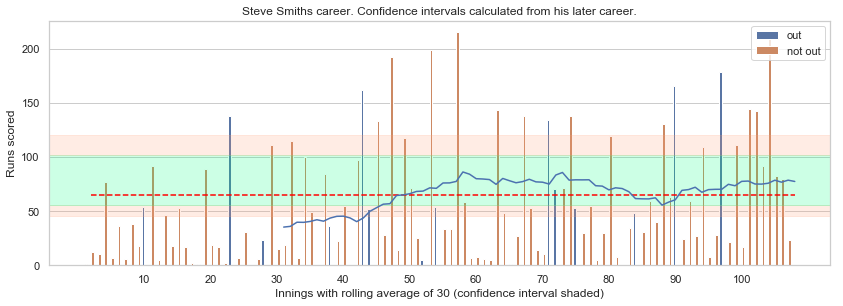

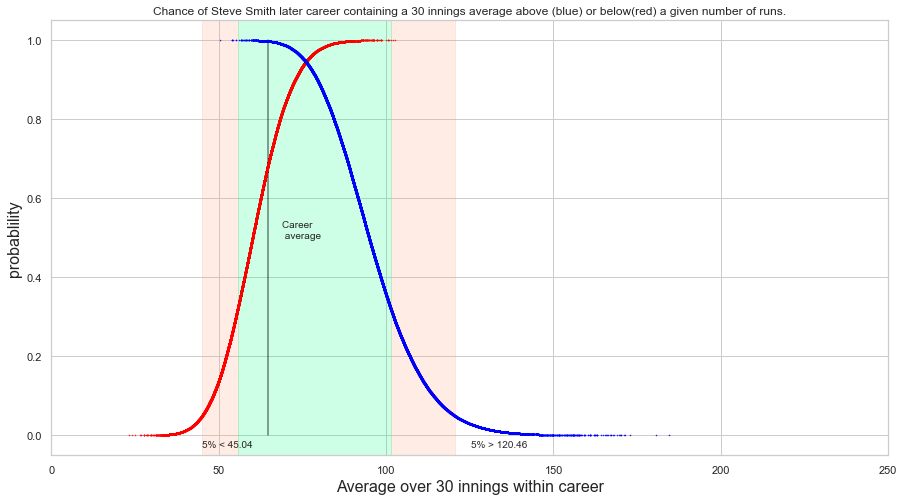

In [11]:
############################
###### SET PARAMETERS ######
############################

num_samples = 100000 #100000 samples takes about 2 seconds to generate runs_array and outs_array
runslist = smith # target player
window_size = 30 #window size to rolling average over
ci = 0.95 #confidence intervals to plot


#############################
###### DATA PROCESSING ######
#############################

#select Smiths batting statistics
smith = batting_stats.loc[batting_stats['batsman'] == 'SPD Smith']

#to sort the career scores of a player we need to get the date of each match from the 
# match_information dataframe. This can be joined on match_id

match_dates = match_information[['start_date','match_id']]

smith = pd.merge(smith, match_dates, how='left', on='match_id')

smith = smith.sort_values(by = ['start_date', 'innings'])
smith.reset_index(inplace=True, drop=True)
smith['index'] = list(range(1,1+smith.shape[0]))
smith = smith[['innings','runs','out','index']]
#manually add last two matches in 2019 ashes campaign
df2 = pd.DataFrame([[1, 211, 1, 104], [3, 82, 1, 105], [1, 80, 1, 106], [3, 23, 1, 107]], columns=('innings','runs','out','index'))
smith = smith.append(df2)


###########################
###### BOOTSTRAPPING ######
###########################

#Generate bootstrapped careers and find confidence intervals

#Steve Smith

average_rolling = bootstrap_rolling_averages(runslist, num_samples, window_size)

#now need to perform row-wise checks against a target value  to see if any value in that row falls below the target
#the second check and sum is to convert multiple matches within a single column to a single match.
criteria_matches = ((average_rolling < 9.5).sum(axis=1) >0).mean()



#generate rolling averages for 'smith' 
runslist['roll_av'] = runslist.runs.rolling(window_size, center=False).sum() / runslist.out.rolling(window_size, center=False).sum()
smith_mean = runslist.runs.sum() / runslist.out.sum()


#first 5 rolling averages of smiths career
print('first 5 rolling averages')
print(runslist['roll_av'][window_size-1:window_size+4])


######################
###### PLOTTING ######
######################


#plot bar graphs of the results
fig, ax2 = plt.subplots(1,1, figsize=(14,4.5)) #set shared axis ticks 

#plot an average
x= runslist['index']
x= [x.iloc[0], x.iloc[-1]]
y= [smith_mean,smith_mean]
ax2.plot(x,y,color='red',linestyle='--')


plot_ = sns.barplot(x = 'index', y = 'runs', hue='out', data = runslist, ax=ax2)
x = runslist['index']
ax2.plot(x=[x.iloc[0], x.iloc[-1]], y= [smith_mean,smith_mean])
plot_roll_av = sns.lineplot(x='index', y='roll_av', data=runslist, ax=ax2)
ax2.set_title('Steve Smiths career. Confidence intervals calculated from his later career.')
ax2.set_ylabel('Runs scored')
ax2.set_xlabel('Innings with rolling average of {} (confidence interval shaded)'.format(window_size))
for label in plot_.get_xticklabels():
    if np.int(label.get_text()) % 10 == 0:  
        label.set_visible(True)
    else:
        label.set_visible(False)


## Restrict ECDF sampling to later part of Smiths career

runslist_trunc = runslist.iloc[window_size:,:]
    
#Generate an ECDF Plot
average_rolling = bootstrap_rolling_averages(runslist_trunc, num_samples, window_size)
lower_bound, lower_std, upper_std, upper_bound = ecdf_batting(runslist, window_size, average_rolling, 'Steve Smith later')


##Add confidence intervals to the bar plots

#shade confidence interval
ax2.axhspan(lower_bound, lower_std, alpha=0.2, color='lightsalmon')
ax2.axhspan(lower_std, upper_std, alpha=0.2, color='springgreen')
ax2.axhspan(upper_std, upper_bound, alpha=0.2, color='lightsalmon')

handles, _ = ax2.get_legend_handles_labels()
ax2.legend(handles, ["out", "not out"])



print('Smiths batting career with confidence intervals calculated from his later career.')



### 5.1 Results

Adjusting the window size from 20 innings to 40 innings there were no periods where Smiths early career exceeds a 95% confidence interval. That said Smith did consistently fall close to the confidence interval over varying window sizes. 

However if we assume that Smiths performance increase is due to a temporal change (an absolute improvement over time) then we can restrict sampling for the ECDF graph to innings recorded after 'window_size'. When this is performed the rolling averages of Smiths early career are significantly lower than the 95% confidence interval. For a window size of 30 the 95% ci is 45.04 runs and Smiths first 4 rolling averages are below 40 runs. This indicates that there is a strong possibility that Smiths performance has increased from his early career to his late career.

Not all batsmen has a consistent improvement in their average from their early career, and any improvement does not necessarily occur over the same timeframe. For this reason I do not provide a comparitive analysis using multiple batsmen, as I did in the case of the poor form analysis. With that being said a more sophisticated look into improvement over a career may be of interest.

## 6. Summary 